In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Padding

In [2]:
def pad_with_zeros(X, n_pads):
    """
    Argument:
    X -- python numpy array of shape (m, n_H, n_W, n_C) representing a batch of m images
    n_pads -- integer, amount of padding around each image on vertical and horizontal dimensions
    
    Returns:
    X_padded -- padded image of shape (m, n_H + 2 * n_pads, n_W + 2 * n_pads, n_C)
    """

    X_padded = np.pad(X, ((0,0), (n_pads,n_pads), (n_pads,n_pads), (0,0)), mode='constant', constant_values = (0,0))
    return X_padded

x.shape = (1, 3, 3, 3)
x_padded.shape = (1, 9, 9, 3)


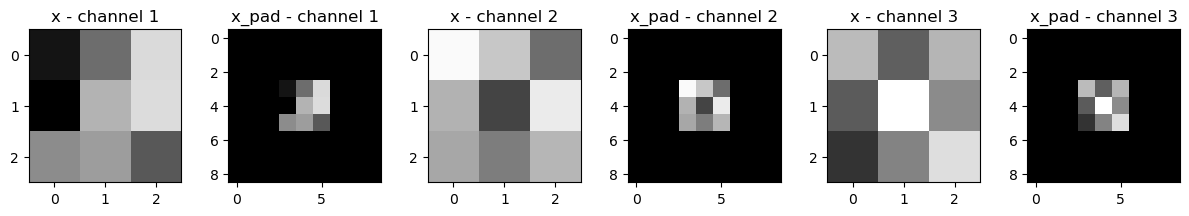

In [3]:
x = np.random.randn(1, 3, 3, 3)
x = (x - np.min(x)) / (np.max(x) - np.min(x))
x_padded = pad_with_zeros(x, n_pads=3)

print('x.shape =', x.shape)
print('x_padded.shape =', x_padded.shape)

fig, axes = plt.subplots(1, 6, figsize=(12, 8))
axes = axes.flatten()  # Flatten the 2D array of axes

for i in range(3):
    axes[i*2].set_title(f'x - channel {i+1}')
    axes[i*2].imshow(x[0, :, :, i], cmap='gray', vmin=0, vmax=1)
    
    axes[i*2+1].set_title(f'x_pad - channel {i+1}')
    axes[i*2+1].imshow(x_padded[0, :, :, i], cmap='gray', vmin=0, vmax=1)

plt.tight_layout()
plt.show()

# Forward Pass of Conv_Layer

In [4]:
def convolute(a_sliced_prev, w, b):
    """
    Arguments:
    a_sliced_prev -- slice of input data of shape (f, f, n_C_prev)
    w -- Weights in a window - matrix of shape (f, f, n_C_prev)
    b -- Bias in a window - matrix of shape (1, 1, 1)
    
    Returns:
    z -- a scalar value, the result of convolving the sliding window (W, b) on a slice x of the input data
    """

    z = np.sum(a_sliced_prev * w) + b.item()  # Extract the scalar value from the array b
    return z

In [5]:
np.random.seed(1)
a_slice_prev = np.random.randn(4, 4, 3)
w = np.random.randn(4, 4, 3)
b = np.random.randn(1, 1, 1)

z = convolute(a_slice_prev, w, b)
print("Z =", z)

Z = -6.999089450680221


The formulas relating the output shape of the convolution to the input shape are:
    
$$n_H = \Bigl\lfloor \frac{n_{H_{prev}} - f + 2 \times pad}{stride} \Bigr\rfloor +1$$
$$n_W = \Bigl\lfloor \frac{n_{W_{prev}} - f + 2 \times pad}{stride} \Bigr\rfloor +1$$
$$n_C = \text{number of filters used in the convolution}$$
    



For this exercise, don't worry about vectorization! Just implement everything with for-loops.

In [6]:
def forward_conv(A_prev, W, B, padding, strides):
    """
    Arguments:
    A_prev -- output of the previous layer, numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    W -- Weights, numpy array of shape (f, f, n_C_prev, n_C)
    B -- Biases, numpy array of shape (1, 1, 1, n_C)
    padding -- int, the amount of zero-padding to add around the border
    strides -- tuple of two ints, (stride_h, stride_w), the strides for height and width
    
    Returns:
    Z -- conv output, numpy array of shape (m, n_H, n_W, n_C)
    cache -- cache of values needed for the backward_conv() function
    """
    m, n_H_prev, n_W_prev, n_C_prev = A_prev.shape
    f, _, _, n_C = W.shape
    stride_H, stride_W = strides
    
    n_H = int((n_H_prev - f + 2*padding) / stride_H) + 1
    n_W = int((n_W_prev - f + 2*padding) / stride_W) + 1

    A_prev = pad_with_zeros(A_prev, n_pads=padding)

    Z = np.zeros((m, n_H, n_W, n_C))
    
    for i in range(m):
        a_prev = A_prev[i]  # take 1 sample
        
        for h in range(n_H):
            start_H = h * stride_H
            end_H = start_H + f

            for w in range(n_W):
                start_W = w * stride_W
                end_W = start_W + f

                for c in range(n_C):
                    a_sliced = a_prev[start_H:end_H, start_W:end_W, :]  # take a slice across 3D of 1 sample
                    Z[i, h, w, c] = convolute(a_sliced, W[..., c], B[..., c])

    cache = (A_prev, W, B, padding, strides)
    return Z, cache

In [7]:
np.random.seed(1)
A_prev = np.random.randn(2, 5, 7, 4)
W = np.random.randn(3, 3, 4, 8)
B = np.random.randn(1, 1, 1, 8)

padding = 1
strides = (2,2)

Z, _ = forward_conv(A_prev, W, B, padding, strides)
print('Z.shape =', Z.shape)
Z[0, 2, 1]

Z.shape = (2, 3, 4, 8)


array([-2.17796037,  8.07171329, -0.5772704 ,  3.36286738,  4.48113645,
       -2.89198428, 10.99288867,  3.03171932])

# Forward Pass of Pooling Layer

As there's no padding, the formulas binding the output shape of the pooling to the input shape is:

$$n_H = \Bigl\lfloor \frac{n_{H_{prev}} - f}{stride} \Bigr\rfloor +1$$

$$n_W = \Bigl\lfloor \frac{n_{W_{prev}} - f}{stride} \Bigr\rfloor +1$$

$$n_C = n_{C_{prev}}$$

In [11]:
def forward_pool(A_prev, f, strides, mode='max'):
    m, n_H_prev, n_W_prev, n_C_prev = A_prev.shape
    stride_H, stride_W = strides

    n_H = int((n_H_prev - f) / stride_H) + 1
    n_W = int((n_W_prev - f) / stride_W) + 1
    n_C = n_C_prev

    A = np.zeros((m, n_H, n_W, n_C))
    
    for i in range(m):
        a_prev = A_prev[i]  # take 1 sample
    
        for h in range(n_H):
            start_H = h * stride_H
            end_H = start_H + f
    
            for w in range(n_W):
                start_W = w * stride_W
                end_W = start_W + f
    
                for c in range(n_C):
                    a_sliced = a_prev[start_H:end_H, start_W:end_W, c]  # take a slice across a channel of 1 sample
    
                    if mode == 'max':
                        A[i, h, w, c] = np.max(a_sliced)
                    elif mode == 'average':
                        A[i, h, w, c] = np.mean(a_sliced)

    cache = (A_prev, f, strides)
    return A, cache

In [15]:
# Case 1: stride of 1
np.random.seed(1)
A_prev = np.random.randn(2, 5, 5, 3)

f = 3
strides = (1,1)

A_max, _ = forward_pool(A_prev, f, strides, mode='max')
A_average, _ = forward_pool(A_prev, f, strides, mode='average')
print('A_max.shape =', A_max.shape)
print('A_average.shape =', A_average.shape)
A_max[1,1], A_average[1,1]

A_max.shape = (2, 3, 3, 3)
A_average.shape = (2, 3, 3, 3)


(array([[1.96710175, 0.84616065, 1.27375593],
        [1.96710175, 0.84616065, 1.23616403],
        [1.62765075, 1.12141771, 1.2245077 ]]),
 array([[ 0.44497696, -0.00261695, -0.31040307],
        [ 0.50811474, -0.23493734, -0.23961183],
        [ 0.11872677,  0.17255229, -0.22112197]]))

In [17]:
# Case 2: stride of 2
np.random.seed(1)
A_prev = np.random.randn(2, 5, 5, 3)

f = 3
strides = (2,2)

A_max, _ = forward_pool(A_prev, f, strides, mode='max')
A_average, _ = forward_pool(A_prev, f, strides, mode='average')
print('A_max.shape =', A_max.shape)
print('A_average.shape =', A_average.shape)
A_max[0], A_average[1]

A_max.shape = (2, 2, 2, 3)
A_average.shape = (2, 2, 2, 3)


(array([[[1.74481176, 0.90159072, 1.65980218],
         [1.74481176, 1.6924546 , 1.65980218]],
 
        [[1.13162939, 1.51981682, 2.18557541],
         [1.13162939, 1.6924546 , 2.18557541]]]),
 array([[[-0.17313416,  0.32377198, -0.34317572],
         [ 0.02030094,  0.14141479, -0.01231585]],
 
        [[ 0.42944926,  0.08446996, -0.27290905],
         [ 0.15077452,  0.28911175,  0.00123239]]]))

# Backpropagation